# Spatial analysis functions 

In [54]:
# required packages 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time
import sys

from sklearn.cluster import MiniBatchKMeans
import seaborn as sns


import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time
import sys

import plotnine

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time
import sys
import matplotlib.pyplot as plt
import math
import os
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns
import scanpy as sc
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Overview

In [1]:
import schemdraw
from schemdraw import flow


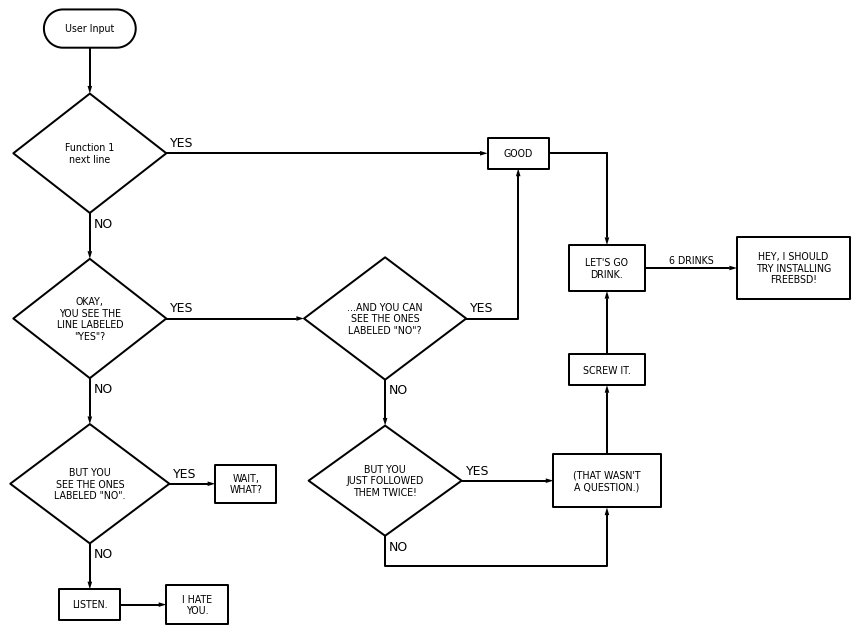

In [2]:
with schemdraw.Drawing() as d:
    d.config(fontsize=11)
    d += (b := flow.Start().label('User Input'))
    d += flow.Arrow().down(d.unit/2)
    d += (d1 := flow.Decision(w=5, h=3.9, E='YES', S='NO').label('Function 1\nnext line'))
    d += flow.Arrow().length(d.unit/2)
    d += (d2 := flow.Decision(w=5, h=3.9, E='YES', S='NO').label('OKAY,\nYOU SEE THE\nLINE LABELED\n"YES"?'))
    d += flow.Arrow().length(d.unit/2)
    d += (d3 := flow.Decision(w=5.2, h=3.9, E='YES', S='NO').label('BUT YOU\nSEE THE ONES\nLABELED "NO".'))

    d += flow.Arrow().right(d.unit/2).at(d3.E)
    d += flow.Box(w=2, h=1.25).anchor('W').label('WAIT,\nWHAT?')
    d += flow.Arrow().down(d.unit/2).at(d3.S)
    d += (listen := flow.Box(w=2, h=1).label('LISTEN.'))
    d += flow.Arrow().right(d.unit/2).at(listen.E)
    d += (hate := flow.Box(w=2, h=1.25).anchor('W').label('I HATE\nYOU.'))

    d += flow.Arrow().right(d.unit*3.5).at(d1.E)
    d += (good := flow.Box(w=2, h=1).anchor('W').label('GOOD'))
    d += flow.Arrow().right(d.unit*1.5).at(d2.E)
    d += (d4 := flow.Decision(w=5.3, h=4.0, E='YES', S='NO').anchor('W').label('...AND YOU CAN\nSEE THE ONES\nLABELED "NO"?'))

    d += flow.Wire('-|', arrow='->').at(d4.E).to(good.S)
    d += flow.Arrow().down(d.unit/2).at(d4.S)
    d += (d5 := flow.Decision(w=5, h=3.6, E='YES', S='NO').label('BUT YOU\nJUST FOLLOWED\nTHEM TWICE!'))
    d += flow.Arrow().right().at(d5.E)
    d += (question := flow.Box(w=3.5, h=1.75).anchor('W').label("(THAT WASN'T\nA QUESTION.)"))
    d += flow.Wire('n', k=-1, arrow='->').at(d5.S).to(question.S)

    d += flow.Line().at(good.E).tox(question.S)
    d += flow.Arrow().down()
    d += (drink := flow.Box(w=2.5, h=1.5).label("LET'S GO\nDRINK."))
    d += flow.Arrow().right().at(drink.E).label('6 DRINKS')
    d += flow.Box(w=3.7, h=2).anchor('W').label('HEY, I SHOULD\nTRY INSTALLING\nFREEBSD!')
    d += flow.Arrow().up(d.unit*.75).at(question.N)
    d += (screw := flow.Box(w=2.5, h=1).anchor('S').label('SCREW IT.'))
    d += flow.Arrow().at(screw.N).toy(drink.S)

## Load example dataset 

In [21]:
df = pd.read_csv("/Users/timnoahkempchen/Desktop/SAP/Data/22_08_09_CellAtlas_only_Processed_Metadata_subsample10k.csv")
df.columns

Index(['...1', 'CHGA', 'MMP9', 'CD36', 'CK7', 'PDL1', 'Bcatenin', 'Vimentin',
       'FoxP3', 'CD56', 'CD31', 'pH2AX', 'CD90', 'CD15', 'PD1', 'aSMA', 'CD25',
       'Ki67', 'Cytokeratin', 'CD20', 'CD4', 'CD11c', 'AnnexA1', 'Nestin',
       'p53', 'CD73', 'EGFR', 'MUC5AC', 'HLADR', 'COX2', 'BCL2', 'p63', 'CD3',
       'MUC2', 'CD8', 'CD45', 'PGA3', 'CD57', 'CD68', 'aDef5', 'CD34',
       'Podoplanin', 'CD38', 'CD11b', 'CD163', 'MUC1', 'CD138', 'Arginase1',
       'PP', 'CD79a', 'MUC6', 'region', 'x', 'y', 'sample', 'region_num',
       'CD206', 'CollIV', 'unique_region', 'Accession_number', 'Block_ID',
       'Sample_type', 'neigh_name', 'neigh_sub', 'community',
       'community common', 'Cell Type', 'Core Type', 'Accession number',
       'Sample', 'Block type', 'Initial block diagnosis', '% invasive',
       '%dysplasia', '%metaplasia+columnar', '% normal squam mucosa',
       '% HG dyspalsia', '% LG dysplasia', '% Glandular', '% metaplasia',
       'consensus diagnosis', 'Sub diagn

In [48]:
# Shannon diversity
# Set filepaths 
input_filepath = "/Users/timnoahkempchen/Library/CloudStorage/GoogleDrive-timkem@stanford.edu/Meine Ablage/Datasets/data/22_08_09_CellAtlas_only_Processed_Metadata.csv"
output_filepath = "/Users/timnoahkempchen/Downloads/Output_test"

# mandatory 
## define column that defines replicates 
rep ='unique_region'

## specify column used to group the data 
group_com = 'community' # order can specify the order in which group_com is plotted on the x axis 
# used by helper function 
## a column name from the input dataframe, defines the category for which the percentage will be calculated
per_categ = 'Cell Type' 
## a column name from the input dataframe, defines a subset of the data to use
sub_column = 'Major Cell Cat'
## define string which is used to subset sub_column  
sub_l = ['Immune','Epithelial','Mesenchymal']

# optional
## Set specific colors for figure 
coloring = None
## Specify order for x axis 
ordering = None 
## Save figure - boolean 
save = True
## change figure size 
fig_size=8

# Stacked bar plot
per_cat = "Major Cell Cat"
grouping = 'consensus diagnosis'

norm=True
save_name= 'Major_subConsensus'

sub_col= 'Cell Type'
name_cat = 'Cell Type'
fig_sizing=(8,4)

pal_color=None
remove_leg=False
save_path = "/Users/timnoahkempchen/Downloads/TestFolder/"

# Swarm plot 
sub_list = ['CD4+ Treg']

/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_1989/3299100996.py:38: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


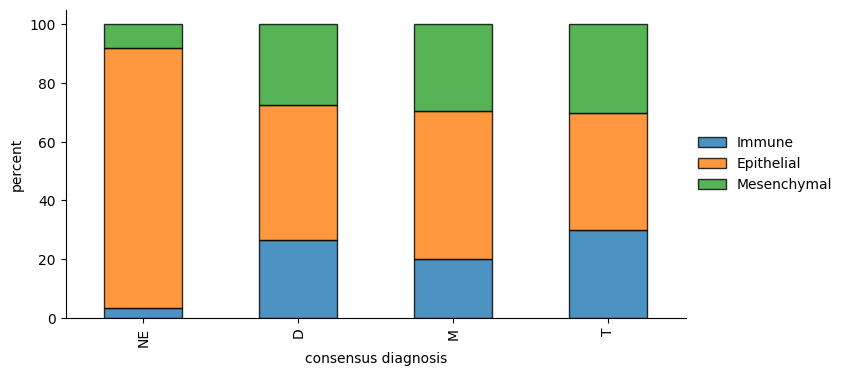

In [46]:
#order_tis = ['M1 Macrophage', 'M2 Macrophage']
#h_ordertu = ['Mucosa', 'Muscularis mucosa', 'Submucosa', 'Muscularis externa']
ab = stacked_bar_plot(data = df, per_cat = per_cat, grouping = grouping, sub_col= None,\
          cell_list = cell_list, norm=False,fig_sizing=fig_sizing, name_cat = per_cat,  \
                    col_order=None, save_name=save_name, pal_color=pal_color,) #h_order=h_ordertu,  pal_color=col_map

/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_1989/1811191355.py:44: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


<Figure size 150x300 with 0 Axes>

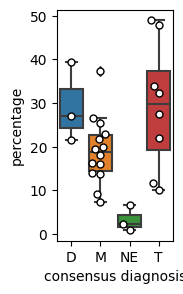

In [49]:
total_neigh_st = swarm_box(data=df, grouping=grouping, replicate= rep,\
                           sub_col=sub_col, sub_list=sub_list, norm=False, per_cat= per_cat, \
                           figure_sizing=(1.5,3), save_name='sig_imm_cons', pal_color=None, h_order=None,\
                           flip=True)

/Users/timnoahkempchen/opt/anaconda3/envs/spatial_analysis_environment/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_1989/1151995878.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
/Users/timnoahkempchen/opt/anaconda3/envs/spatial_analysis_environment/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 13.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


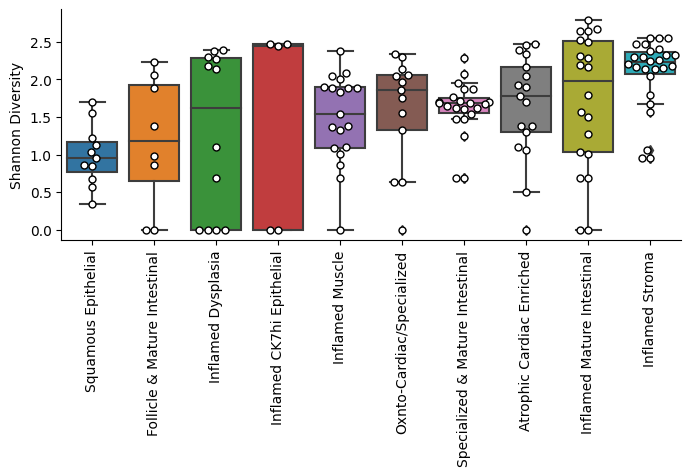

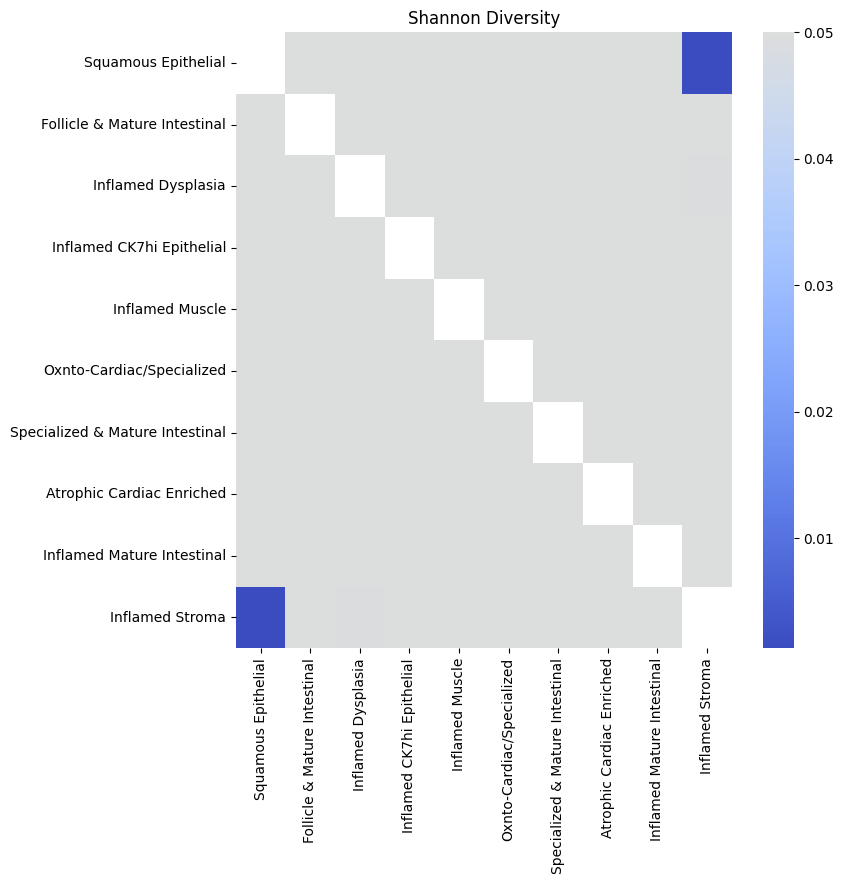

In [58]:
# use function 
# for different conditions
result, pval, tukey_tab = Shan_div(data1=df, sub_l = sub_l,\
        group_com = group_com, per_categ = per_categ,\
        rep=rep, sub_column=sub_column,normalize=True, save=save,\
                          coloring= coloring, fig_size=fig_size, ordering=None, output_filepath = output_filepath)

## Cell_type percent

Arguments:
- data: the input data for the plot, which should be a pandas DataFrame
- per_cat: the name of the column in the input data that specifies the categories for the stacked bars
- grouping: the name of the column in the input data that specifies the grouping variable
- cell_list: a list of the cell types to include in the plot
- norm: a boolean indicating whether to normalize the data
- save_name: the name of the file to save the plot as *(optional)*
- col_order: a list specifying the order of the groups to appear on the x-axis
- sub_col: the name of a sub-column to group the data by *(optional)*
- name_cat: the name to give to the per_cat column in the resulting plot
- fig_sizing: a tuple specifying the size of the plot in inches
- h_order: a list specifying the order of the categories to appear within each group *(optional)*
- pal_color: a dictionary mapping categories to colors *(optional)*
- remove_leg: a boolean indicating whether to remove the legend from the plot *(optional)*

The minimal input parameters for the stacked_bar_plot function are:
- data: a Pandas DataFrame containing the data to be plotted.
- per_cat: a string indicating the name of the column in data containing the categorical variable to be plotted.
- grouping: a string indicating the name of the column in data containing the grouping variable for the plot.
- cell_list: a list of strings indicating the categories to be plotted for per_cat.

In [27]:
def stacked_bar_plot(data, per_cat, grouping, cell_list, norm=True, save_name=None,\
              col_order=None, sub_col=None, name_cat = 'Cell Type',fig_sizing=(8,4),\
                     h_order=None, pal_color=None,remove_leg=False):
    
    #Find Percentage of cell type
    if norm==True:
        if sub_col is None:
            test1 = data.loc[data[per_cat].isin(cell_list)]
            sub_cell_list = list(test1[per_cat].unique())
        else:
            test1 = data.loc[data[sub_col].isin(cell_list)]
            sub_cell_list = list(test1[per_cat].unique())
    else:
        if sub_col is None:
            test1 = data.copy()
            sub_cell_list = list(data.loc[data[per_cat].isin(cell_list)][per_cat].unique())
        else:
            test1 = data.copy()
            sub_cell_list = list(data.loc[data[sub_col].isin(cell_list)][per_cat].unique())
            
    test1[per_cat] = test1[per_cat].astype('category')
    test_freq = test1.groupby(grouping).apply(lambda x: x[per_cat].value_counts(normalize = True,sort = False)*100)
    test_freq.columns = test_freq.columns.astype(str)
    
    ##### Can subset it here if I do not want normalized per the group
    test_freq.reset_index(inplace=True)
    sub_cell_list.append(grouping)
    test_freq = test_freq[sub_cell_list]
    melt_test = pd.melt(test_freq, id_vars=[grouping])#, value_vars=test_freq.columns)
    melt_test.rename(columns = {per_cat: name_cat, 'value':'percent'},  inplace = True)
    
    if norm==True:
        if col_order is None:
            bb = melt_test.groupby([grouping, per_cat]).sum().reset_index()
            col_order = bb.loc[bb[per_cat]==bb[per_cat][0]].sort_values(by='percent')[grouping].to_list()
    else:    
        if col_order is None:
            col_order = melt_test.groupby(grouping).sum().reset_index().sort_values(by='percent')[grouping].to_list()
    
    if h_order is None:
        h_order = list(melt_test[per_cat].unique()) 
    
    #Set up for plotting
    melt_test_piv = pd.pivot_table(melt_test, columns = [name_cat], index=[grouping], values=['percent'])
    melt_test_piv.columns = melt_test_piv.columns.droplevel(0)
    melt_test_piv.reset_index(inplace=True)
    melt_test_piv.set_index(grouping, inplace=True)
    melt_test_piv = melt_test_piv.reindex(col_order)
    melt_test_piv = melt_test_piv[h_order]
    
    #Get color dictionary 
    if pal_color is None:
        #first subplot
        ax1 = melt_test_piv.plot.bar(alpha = 0.8, linewidth=1,\
                                    figsize =fig_sizing, rot=90,stacked=True, edgecolor='black')

    else: 
        #first subplot
        ax1 = melt_test_piv.plot.bar(alpha = 0.8, linewidth=1, color=[pal_color.get(x) for x in melt_test_piv.columns],\
                                    figsize =fig_sizing, rot=90,stacked=True, edgecolor='black')

    for line in ax1.lines:
        line.set_color('black')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    if remove_leg==True:
        ax1.set_ylabel('')
        ax1.set_xlabel('')
    else:
        ax1.set_ylabel('percent')
    #ax1.spines['left'].set_position(('data', 1.0))
    #ax1.set_xticks(np.arange(1,melt_test.day.max()+1,1))
    #ax1.set_ylim([0, int(ceil(max(max(melt_test_piv.sum(axis=1)), max(tm_piv.sum(axis=1)))))])
    plt.xticks(list(range(len(list(melt_test_piv.index)))), list(melt_test_piv.index), rotation=90)
    lgd2 = ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, frameon=False)
    if save_name:
        plt.savefig(save_path+save_name+'.png', format='png',\
                    dpi=300, transparent=True, bbox_inches='tight')
    return melt_test_piv, h_order    

Minimal Input: 
- data: a pandas DataFrame containing the data to plot.
- grouping: a string specifying the name of the column in data to use for grouping the data.
- replicate: a string specifying the name of the column in data to use for replicates.
- sub_col: a string specifying the name of the column in data to use as a subset for the plot.
- sub_list: a list of values from sub_col to use for the plot.
- per_cat: a string specifying the name of the column in data to use for calculating percentages.

Arguments:
- data: A pandas DataFrame containing the data to be plotted.
- grouping: A string representing the column in data to group by for plotting.
- replicate: A string representing the column in data to group replicates by for plotting.
- sub_col: A string representing the column in data to subset by using sub_list.
- sub_list: A list containing values to subset data by using sub_col.
- per_cat: A string representing the column in data to represent as categories in the plot.
- norm: A Boolean flag to normalize the data (default True).
- figure_sizing: A tuple representing the size of the figure to be plotted (default (10, 5)).
- save_name: A string representing the name of the file to save the plot to. If not specified, the plot will not be saved.
- h_order: A list representing the order of the grouping levels to be plotted. If not specified, the order will be determined from the data.
- col_in: A list representing the categories to be plotted. If not specified, all categories will be plotted.
- pal_color: A color palette to be used for plotting. If not specified, the default palette will be used.
- flip: A Boolean flag to determine the orientation of the plot (default False).

In [28]:
def swarm_box(data, grouping, replicate, sub_col, sub_list, per_cat, norm=True,\
              figure_sizing=(10,5), save_name=None, h_order=None, col_in=None, \
              pal_color=None, flip=False):
       
    #Find Percentage of cell type
    if norm==True:
        test1 = test.loc[data[sub_col].isin(sub_list)]
        immune_list = list(test1[per_cat].unique())
    else:
        test1=data.copy()
        immune_list = list(data.loc[data[sub_col].isin(sub_list)][per_cat].unique())
    
    test1[per_cat] = test1[per_cat].astype('category')
    test_freq = test1.groupby([grouping,replicate]).apply(lambda x: x[per_cat].value_counts(normalize = True,sort = False)*100)
    test_freq.columns = test_freq.columns.astype(str)
    test_freq.reset_index(inplace=True)
    immune_list.extend([grouping,replicate])
    test_freq1 = test_freq[immune_list]

    melt_per_plot = pd.melt(test_freq1, id_vars=[grouping,replicate,])#,value_vars=immune_list)
    melt_per_plot.rename(columns={'value': 'percentage'}, inplace=True)
    
    if col_in:
        melt_per_plot = melt_per_plot.loc[melt_per_plot[per_cat].isin(col_in)]
    else:
        melt_per_plot = melt_per_plot
    
    #Order by average
    plot_order = melt_per_plot.groupby(per_cat).mean().reset_index().sort_values(by='percentage')[per_cat].to_list()

    if h_order is None:
        h_order = list(melt_per_plot[grouping].unique()) 
    
    #Get color dictionary 
    if pal_color is None:
            #swarmplot to compare clustering
        plt.figure(figsize=figure_sizing)
        if flip==True:
            plt.figure(figsize=figure_sizing)
            ax = sns.boxplot(data = melt_per_plot, x=grouping,  y='percentage',  dodge=True,order=h_order)
                           
            ax = sns.swarmplot(data = melt_per_plot, x=grouping, y='percentage', dodge=True,order=h_order,\
                            edgecolor='black',linewidth=1, color="white")
        
            for patch in ax.artists:
                r, g, b, a = patch.get_facecolor()
                patch.set_facecolor((r, g, b, .3))
            plt.xticks(rotation=90)
            plt.xlabel('')
            plt.ylabel('')
            plt.title(sub_list[0])
            sns.despine()
            
        else:
            ax = sns.boxplot(data = melt_per_plot, x=per_cat,  y='percentage', hue = grouping, dodge=True, order=plot_order,\
                            hue_order=h_order)
            ax = sns.swarmplot(data = melt_per_plot, x=per_cat, y='percentage', hue = grouping, dodge=True, order=plot_order,\
                            hue_order=h_order, edgecolor='black',linewidth=1)
            for patch in ax.artists:
                r, g, b, a = patch.get_facecolor()
                patch.set_facecolor((r, g, b, .3))
            #ax.set_yscale(\log\)
            plt.xlabel('')
            handles, labels = ax.get_legend_handles_labels()
            plt.legend(handles[:len(melt_per_plot[grouping].unique())], labels[:len(melt_per_plot[grouping].unique())],\
                    bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)
            plt.xticks(rotation=90)

            ax.set(ylim=(0,melt_per_plot['percentage'].max()+1))
            sns.despine()
        if save_name:
            plt.savefig(save_path+save_name+'_swarm_boxplot.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
        
        

    else:

    
        #swarmplot to compare clustering
        plt.figure(figsize=figure_sizing)
        if flip==True:
            plt.figure(figsize=figure_sizing)
            ax = sns.boxplot(data = melt_per_plot, x=grouping,  y='percentage',  dodge=True,order=h_order, \
                            palette=pal_color)
            ax = sns.swarmplot(data = melt_per_plot, x=grouping, y='percentage', dodge=True,order=h_order,\
                            edgecolor='black',linewidth=1, palette=pal_color)
        
            for patch in ax.artists:
                r, g, b, a = patch.get_facecolor()
                patch.set_facecolor((r, g, b, .3))
            plt.xticks(rotation=90)
            plt.xlabel('')
            plt.ylabel('')
            plt.title(sub_list[0])
            sns.despine()
            
        else:
            ax = sns.boxplot(data = melt_per_plot, x=per_cat,  y='percentage', hue = grouping, dodge=True, order=plot_order,\
                            hue_order=h_order, palette=pal_color)
            ax = sns.swarmplot(data = melt_per_plot, x=per_cat, y='percentage', hue = grouping, dodge=True, order=plot_order,\
                            hue_order=h_order, edgecolor='black',linewidth=1, palette=pal_color)
            for patch in ax.artists:
                r, g, b, a = patch.get_facecolor()
                patch.set_facecolor((r, g, b, .3))
            #ax.set_yscale(\log\)
            plt.xlabel('')
            handles, labels = ax.get_legend_handles_labels()
            plt.legend(handles[:len(melt_per_plot[grouping].unique())], labels[:len(melt_per_plot[grouping].unique())],\
                    bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)
            plt.xticks(rotation=90)

            ax.set(ylim=(0,melt_per_plot['percentage'].max()+1))
            sns.despine()
        if save_name:
            plt.savefig(save_path+save_name+'_swarm_boxplot.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
        
    return melt_per_plot

Annotated version

In [31]:
# This function creates a box plot and swarm plot from the given data
# and returns a plot object.

def swarm_box(data, grouping, replicate, sub_col, sub_list, per_cat, norm=True, \
              figure_sizing=(10,5), save_name=None, h_order=None, col_in=None, \
              pal_color=None, flip=False):
       
    # If norm is True, get the percentage of cell type by subsetting the data
    # and computing the unique values of a given category column. Otherwise,
    # copy the entire data.
    
    if norm==True:
        test1 = test.loc[data[sub_col].isin(sub_list)]
        immune_list = list(test1[per_cat].unique())
    else:
        test1=data.copy()
        immune_list = list(data.loc[data[sub_col].isin(sub_list)][per_cat].unique())
    
    # Cast the category column to categorical type.
    test1[per_cat] = test1[per_cat].astype('category')
    
    # Compute the percentage of each category column by group and replicate.
    test_freq = test1.groupby([grouping,replicate]).apply(lambda x: x[per_cat].value_counts(normalize = True,sort = False)*100)
    
    # Convert column names to string type and reset index.
    test_freq.columns = test_freq.columns.astype(str)
    test_freq.reset_index(inplace=True)
    
    # Add grouping and replicate to immune_list and subset the data.
    immune_list.extend([grouping,replicate])
    test_freq1 = test_freq[immune_list]

    # Melt the data frame and rename columns.
    melt_per_plot = pd.melt(test_freq1, id_vars=[grouping,replicate,])
    melt_per_plot.rename(columns={'value': 'percentage'}, inplace=True)
    
    # If col_in is not None, subset melt_per_plot to include only those values.
    if col_in:
        melt_per_plot = melt_per_plot.loc[melt_per_plot[per_cat].isin(col_in)]
    else:
        melt_per_plot = melt_per_plot
    
    # Order the data by average percentage of each category column.
    plot_order = melt_per_plot.groupby(per_cat).mean().reset_index().sort_values(by='percentage')[per_cat].to_list()

    # If h_order is None, use unique values of the grouping column as the order.
    if h_order is None:
        h_order = list(melt_per_plot[grouping].unique()) 
    
    # If pal_color is None, create a figure with box plot and swarm plot
    # for each category column or grouping column based on flip value.
    if pal_color is None:
        # Create a figure and axis object with given figure size.
        plt.figure(figsize=figure_sizing)
        
        # If flip is True, plot box plot and swarm plot for grouping column.
        if flip==True:
            plt.figure(figsize=figure_sizing)
            
            # Create a box plot with given parameters.
            ax = sns.boxplot(data = melt_per_plot, x=grouping,  y='percentage',  dodge=True,order=h_order)
                           
            # Create a swarm plot with given parameters.
            ax = sns.swarmplot(data = melt_per_plot, x=grouping, y='percentage', dodge=True,order=h_order,\
                            edgecolor='black',linewidth=1, color="white")
        
            # Set the transparency of box plot patches.
            for patch in ax.artists:
                r, g, b, a = patch.get_facecolor()
                patch.set_facecolor((r, g, b,)
                )


This is a Python function that calculates the Shannon diversity index and performs an ANOVA test on the results. The function takes in several input parameters and returns several outputs.


Minimal input:
- data1: a pandas DataFrame containing the data for analysis
- sub_l: a list of column names for the subset(s) of the data to be analyzed
- group_com: a string representing the column name for the grouping variable

Arguments:
- data1: a pandas dataframe that contains the data to be analyzed
- sub_l: a list of columns to be used as subcategories in the analysis
- group_com: the name of the column containing the group labels to be analyzed
- per_categ: a list of categories to calculate percentages for each sample
- rep: the name of the column containing replicate information
- sub_column: the name of the column containing subcategory information
- coloring: a color palette to be used for plotting (default is None)
- output_filepath: the filepath where the output figures will be saved
- normalize: a boolean indicating whether the data should be normalized (default is True)
- save: a boolean indicating whether the figures should be saved (default is False)
- ordering: a list specifying the order in which groups should be plotted (default is None)
- fig_size: the size of the output figures (default is 1.5)

In [57]:

# function
# calculates diversity of cell types within a sample 
def Shan_div(data1, sub_l, group_com, per_categ, rep, sub_column, coloring, output_filepath, normalize=True, save=False, \
             ordering=None, fig_size=1.5):
    #calculate Shannon Diversity
    tt = per_only1(data = data1, per_cat = per_categ, grouping = group_com,\
              sub_list=sub_l, replicate=rep, sub_col = sub_column, norm=normalize)
    tt['fraction']= tt['percentage']/100
    tt['Shannon']=tt['fraction']*np.log(tt['fraction'])
    tt.fillna(0,inplace=True)
    sdiv = tt.groupby([rep,group_com]).agg({'Shannon': 'sum'})
    res = sdiv.reset_index()
    res['Shannon Diversity'] = res['Shannon']*-1

    #Run Anova on results
    res_dict = {}
    for treat in list(res[group_com].unique()):
        res_dict[treat] = res.loc[res[group_com]==treat]['Shannon Diversity']

    treat_list = []
    if len(res_dict) > 1:
        for treat in res_dict.keys():
            treat_list.append(res_dict[treat])
        test_results=stats.f_oneway(*treat_list)[1]
    else:
        test_results=stats.f_oneway(res_dict[treat][0])[1]

        
    #Order by average
    if coloring is None:
        if ordering is None:
            plot_order = res.groupby(group_com).mean().reset_index().sort_values(by='Shannon Diversity')[group_com].to_list()    
        else:
            plot_order=ordering
        #Plot the swarmplot of results
        plt.figure(figsize=(fig_size,3))

        ax = sns.boxplot(data = res, x=group_com,  y='Shannon Diversity',  dodge=True, order=plot_order)
                        
        ax = sns.swarmplot(data = res, x=group_com, y='Shannon Diversity', dodge=True, order=plot_order,\
                        edgecolor='black',linewidth=1, color="white")
    
    else:
        if ordering is None:
            plot_order = res.groupby(group_com).mean().reset_index().sort_values(by='Shannon Diversity')[group_com].to_list()    
        else:
            plot_order=ordering
        #Plot the swarmplot of results
        plt.figure(figsize=(fig_size,3))

        ax = sns.boxplot(data = res, x=group_com,  y='Shannon Diversity',  dodge=True, order=plot_order, \
                        palette=coloring)
        ax = sns.swarmplot(data = res, x=group_com, y='Shannon Diversity', dodge=True, order=plot_order,\
                        edgecolor='black',linewidth=1, palette=coloring)

    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.ylabel('Shannon Diversity')
    plt.title('')
    sns.despine()
    if save==True:
        plt.savefig(output_filepath+sub_l[0]+'_Shannon.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
    
    plt.show()
    if test_results < 0.05:
        plt.figure(figsize=(fig_size,fig_size))
        tukey = pairwise_tukeyhsd(endog=res['Shannon Diversity'],
                              groups=res[group_com],
                              alpha=0.05)
        tukeydf = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
        tukedf_rev = tukeydf.copy()
        tukedf_rev.rename(columns={'group1':'groupa','group2':'groupb'}, inplace=True)
        tukedf_rev.rename(columns={'groupa':'group2','groupb':'group1'}, inplace=True)
        tukedf_rev=tukedf_rev[tukeydf.columns]
        tukey_all = pd.concat([tukedf_rev,tukeydf])

        #Plot with tissue order preserved
        table1 = pd.pivot_table(tukey_all, values='p-adj', index=['group1'],
                            columns=['group2'])
        table1=table1[plot_order]
        table1=table1.reindex(plot_order)

        #plt.figure(figsize = (5,5))
        ax=sns.heatmap(table1, cmap='coolwarm',center=0.05,vmax=0.05)
        ax.set_title('Shannon Diversity') 
        ax.set_ylabel('')    
        ax.set_xlabel('')
        if save==True:    
            plt.savefig(output_filepath+sub_l[0]+'_tukey.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
        plt.show()
    else:
        table1=False
    return tt, test_results, table1

In [33]:
# Define function to calculate Shannon Diversity and plot results
def Shan_div(data1, sub_l, group_com, per_categ, rep, sub_column, coloring, output_filepath, normalize=True, save=False, ordering=None, fig_size=1.5):
    
    # Calculate Shannon Diversity for each subgroup within each treatment group using per_only1 function
    tt = per_only1(data = data1, per_cat = per_categ, grouping = group_com, sub_list=sub_l, replicate=rep, sub_col = sub_column, norm=normalize)
    
    # Calculate fraction and Shannon entropy
    tt['fraction']= tt['percentage']/100
    tt['Shannon']=tt['fraction']*np.log(tt['fraction'])
    tt.fillna(0,inplace=True)
    
    # Group by treatment group and replicate and aggregate Shannon entropy scores
    sdiv = tt.groupby([rep,group_com]).agg({'Shannon': 'sum'})
    res = sdiv.reset_index()
    res['Shannon Diversity'] = res['Shannon']*-1

    # Run one-way ANOVA on Shannon Diversity scores for each treatment group
    res_dict = {}
    for treat in list(res[group_com].unique()):
        res_dict[treat] = res.loc[res[group_com]==treat]['Shannon Diversity']
    treat_list = []
    if len(res_dict) > 1:
        for treat in res_dict.keys():
            treat_list.append(res_dict[treat])
        test_results=stats.f_oneway(*treat_list)[1]
    else:
        test_results=stats.f_oneway(res_dict[treat][0])[1]
    
    # Order treatment groups by Shannon Diversity if ordering is not specified
    if coloring is None:
        if ordering is None:
            plot_order = res.groupby(group_com).mean().reset_index().sort_values(by='Shannon Diversity')[group_com].to_list()    
        else:
            plot_order=ordering
        #Plot the swarmplot of results
        plt.figure(figsize=(fig_size,3))
        ax = sns.boxplot(data = res, x=group_com,  y='Shannon Diversity',  dodge=True, order=plot_order)
        ax = sns.swarmplot(data = res, x=group_com, y='Shannon Diversity', dodge=True, order=plot_order,\
                        edgecolor='black',linewidth=1, color="white")
    else:
        if ordering is None:
            plot_order = res.groupby(group_com).mean().reset_index().sort_values(by='Shannon Diversity')[group_com].to_list()    
        else:
            plot_order=ordering
        #Plot the swarmplot of results
        plt.figure(figsize=(fig_size,3))
        ax = sns.boxplot(data = res, x=group_com,  y='Shannon Diversity',  dodge=True, order=plot_order, \
                        palette=coloring)
        ax = sns.swarmplot(data = res, x=group_com, y='Shannon Diversity', dodge=True, order=plot_order,\
                        edgecolor='black',linewidth=1, palette=coloring)

    # Set transparency of boxplot colors to improve visibility of swarmplot
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    
    # Set axis labels and title, remove axis spines, and save plot if specified
    plt

# Neighborhood analysis 

df: a pandas dataframe containing the data to be visualized.

sample_column: the name of the column in the dataframe containing the sample name (default is "sample").

cell_type_column: the name of the column in the dataframe containing the cell type information (default is "Cell Type").

output: the directory to save the generated plots (default is None).

In [34]:
def cell_type_composition_vis(df, sample_column = "sample", cell_type_column = "Cell Type", output = None):
    
    if output == None:
        print("You have defined no output directory!")
    
    #plotting option1
    #pd.crosstab(df['sample'], df['final_cell_types']).plot(kind='barh', stacked=True,figsize = (10,12))
    #plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    #plt.show()
    

    #plotting option2
    ax = pd.crosstab(df[sample_column], df[cell_type_column]).plot(kind='barh', stacked=True,figsize = (10,10))
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    fig = ax.get_figure()
    ax.set(xlabel='count')
    plt.savefig(output +'/cell_types_composition_hstack.png', bbox_inches='tight')

    #plotting option1
    #pd.crosstab(df['sample'], df['final_cell_types']).plot(kind='barh', figsize = (10,10))
    #plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    #plt.show()

    #plotting option2
    ax = pd.crosstab(df[sample_column], df[cell_type_column]).plot(kind='barh', stacked=False,figsize = (10,10))
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    fig = ax.get_figure()
    ax.set(xlabel='count')
    plt.savefig(output +'/cell_types_composition_hUNstack.png', bbox_inches='tight')

    # Cell type percentage 
    st = pd.crosstab(df[sample_column], df[cell_type_column])
    df_perc=(st/np.sum(st, axis = 1)[:,None])* 100
    df_perc
    #df_perc['sample'] = df_perc.index
    #df_perc

    tmp=st.T.apply(
    lambda x: 100 * x / x.sum()
    )

    ax = tmp.T.plot(kind='barh', stacked=True,figsize = (10,10))
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    fig = ax.get_figure()
    ax.set(xlabel='percentage')
    plt.savefig(output +'/cell_types_composition_perc_hstack.png', bbox_inches='tight')

df: pandas dataframe that contains all used columns used for the analysis 

X: the name of the column in the data file to be used as the x coordinate

Y: the name of the column in the data file to be used as the y coordinate

reg: the name of the column in the data file to be used as the unique region (default is 'unique_region')

cluster_col: the name of the column in the data file to be used as the cluster column (default is 'Cell Type')

ks: a list of integers to be used for computing the neighborhoods (default is [20, 30, 35])

save_path: the path to save the result (default is None)

k: an integer to be used as the final neighborhood size (default is 35)

n_neighborhoods: an integer to be used as the number of neighborhoods to be produced (default is 30)

# Clean up this mess!!!

In [35]:
def get_windows(job,n_neighbors):
    start_time,idx,tissue_name,indices = job
    job_start = time.time()
        
    print ("Starting:", str(idx+1)+'/'+str(len(exps)),': ' + exps[idx])

    tissue = tissue_group.get_group(tissue_name)
    to_fit = tissue.loc[indices][[X,Y]].values

    fit = NearestNeighbors(n_neighbors=n_neighbors).fit(tissue[[X,Y]].values)
    m = fit.kneighbors(to_fit)

    #sort_neighbors
    args = m[0].argsort(axis = 1)
    add = np.arange(m[1].shape[0])*m[1].shape[1]
    sorted_indices = m[1].flatten()[args+add[:,None]]

    neighbors = tissue.index.values[sorted_indices]
    
    end_time = time.time()
    
    print ("Finishing:", str(idx+1)+"/"+str(len(exps)),": "+ exps[idx],end_time-job_start,end_time-start_time)
    return neighbors.astype(np.int32)

In [36]:
# Prepare dataframe for neighborhood analysis 

#Import Data
cluster_col = 'Cell Type'

df = pd.read_csv(path_to_data)

df = pd.concat([df,pd.get_dummies(df[cluster_col])],1)
sum_cols = df[cluster_col].unique()
values = df[sum_cols].values

NameError: name 'path_to_data' is not defined

In [37]:
def neighborhood_analysis(df, X = 'x', Y = 'y', reg = 'unique_region', cluster_col = 'Cell Type', ks = [20, 30, 35], save_path = None, k = 35, n_neighborhoods = 30, save_to_csv = False):

    cells = df.copy

    neighborhood_name = "neighborhood"+str(k)

    keep_cols = [X ,Y ,reg,cluster_col]

    n_neighbors = max(ks)

    cells[reg] = cells[reg].astype('str')

    #Get each region
    tissue_group = cells[[X,Y,reg]].groupby(reg)
    exps = list(cells[reg].unique())
    tissue_chunks = [(time.time(),exps.index(t),t,a) for t,indices in tissue_group.groups.items() for a in np.array_split(indices,1)] 

    tissues = [get_windows(job, n_neighbors) for job in tissue_chunks]

    #Loop over k to compute neighborhoods
    out_dict = {}
    for k in ks:
        for neighbors,job in zip(tissues,tissue_chunks):

            chunk = np.arange(len(neighbors))#indices
            tissue_name = job[2]
            indices = job[3]
            window = values[neighbors[chunk,:k].flatten()].reshape(len(chunk),k,len(sum_cols)).sum(axis = 1)
            out_dict[(tissue_name,k)] = (window.astype(np.float16),indices)
            
    windows = {}
    for k in ks:
    
        window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = sum_cols) for exp in exps],0)
        window = window.loc[cells.index.values]
        window = pd.concat([cells[keep_cols],window],1)
        windows[k] = window

    #Fill in based on above
    k_centroids = {}

    #producing what to plot
    windows2 = windows[k]
    windows2[cluster_col] = cells[cluster_col]

    km = MiniBatchKMeans(n_clusters = n_neighborhoods,random_state=0)

    labels = km.fit_predict(windows2[sum_cols].values)
    k_centroids[k] = km.cluster_centers_
    cells[neighborhood_name] = labels

    #modify figure size aesthetics for each neighborhood
    figs = catplot(cells,X = X,Y=Y,exp = reg,hue = 'neighborhood'+str(k),invert_y=True,size = 5,)
    if save_to_csv is True:
        cells.to_csv(save_path + 'neighborhood.csv')
        
    else: 
        print("results will not be stored as csv file")

    #Save Plots for Publication
    for n,f in enumerate(figs):
        f.savefig(save_path+'neighborhood_'+str(k)+'_id{}.png'.format(n))

    #this plot shows the types of cells (ClusterIDs) in the different niches (0-9)
    k_to_plot = k
    niche_clusters = (k_centroids[k_to_plot])
    tissue_avgs = values.mean(axis = 0)
    fc = np.log2(((niche_clusters+tissue_avgs)/(niche_clusters+tissue_avgs).sum(axis = 1, keepdims = True))/tissue_avgs)
    fc = pd.DataFrame(fc,columns = sum_cols)
    s=sns.clustermap(fc, vmin =-3,vmax = 3,cmap = 'bwr')
    s.savefig(save_path+"celltypes_perniche_"+"_"+str(k)+".png", dpi=600)

    #this plot shows the types of cells (ClusterIDs) in the different niches (0-9)
    k_to_plot = k
    niche_clusters = (k_centroids[k_to_plot])
    tissue_avgs = values.mean(axis = 0)
    fc = np.log2(((niche_clusters+tissue_avgs)/(niche_clusters+tissue_avgs).sum(axis = 1, keepdims = True))/tissue_avgs)
    fc = pd.DataFrame(fc,columns = sum_cols)
    s=sns.clustermap(fc.iloc[[0,4,],:], vmin =-3,vmax = 3,cmap = 'bwr')
    s.savefig(save_path+"celltypes_perniche_"+"_"+str(k)+".png", dpi=600)

In [38]:
def get_pathcells(query_database, query_dict_list):
    '''
    Return set of cells that match query_dict path.
    '''
    out = []
    
    if type(query_dict_list) == dict:
        query_dict_list = [query_dict_list]
    
    
    for query_dict in query_dict_list:
        qd = query_database
        for k,v in query_dict.items():
            if type(v)!=list:
                v = [v]
            qd = qd[qd[k].isin(v)]
        out+=[qd]
    if len(query_database)==1:
        return out[0]
    return out

# annotated 
def get_pathcells(query_database: Union[Dict, List[Dict]], query_dict_list: List[Dict]) -> Union[Dict, List[Dict]]:
    '''
    Return set of cells that match query_dict path.
    '''
    out: List[Dict] = []   # initialize an empty list to store results
    
    if type(query_dict_list) == dict:    # if query_dict_list is a dictionary, convert it into a list
        query_dict_list = [query_dict_list]
        
    for query_dict in query_dict_list:    # loop through each dictionary in query_dict_list
        qd = query_database   # initialize a reference to query_database
        for k,v in query_dict.items():   # loop through each key-value pair in the current dictionary
            if type(v)!=list:   # if the value is not a list, convert it into a list
                v = [v]
            qd = qd[qd[k].isin(v)]   # filter the rows of qd based on the key-value pair
        out+=[qd]   # append the resulting qd to the out list
        
    if len(query_database)==1:    # if query_database contains only one row, return the first item in out
        return out[0]
    return out    # otherwise, return the entire out list


class Neighborhoods(object):
    def __init__(self, cells,ks,cluster_col,sum_cols,keep_cols,X='X:X',Y = 'Y:Y',reg = 'Exp',add_dummies = True):
        self.cells_nodumz = cells
        self.X = X
        self.Y = Y
        self.reg = reg
        self.keep_cols = keep_cols
        self.sum_cols = sum_cols
        self.ks = ks
        self.cluster_col = cluster_col
        self.n_neighbors = max(ks)
        self.exps = list(self.cells_nodumz[self.reg].unique())
        self.bool_add_dummies = add_dummies
        
    def add_dummies(self):
        
        c = self.cells_nodumz
        dumz = pd.get_dummies(c[self.cluster_col])
        keep = c[self.keep_cols]
        
        self.cells = pd.concat([keep,dumz],1)
        
        
        
    def get_tissue_chunks(self):
        self.tissue_group = self.cells[[self.X,self.Y,self.reg]].groupby(self.reg)
        
        tissue_chunks = [(time.time(),self.exps.index(t),t,a) for t,indices in self.tissue_group.groups.items() for a in np.array_split(indices,1)] 
        return tissue_chunks
    
    def make_windows(self,job):
        

        start_time,idx,tissue_name,indices = job
        job_start = time.time()

        print ("Starting:", str(idx+1)+'/'+str(len(self.exps)),': ' + self.exps[idx])

        tissue = self.tissue_group.get_group(tissue_name)
        to_fit = tissue.loc[indices][[self.X,self.Y]].values

        fit = NearestNeighbors(n_neighbors=self.n_neighbors+1).fit(tissue[[self.X,self.Y]].values)
        m = fit.kneighbors(to_fit)
        m = m[0][:,1:], m[1][:,1:]


        #sort_neighbors
        args = m[0].argsort(axis = 1)
        add = np.arange(m[1].shape[0])*m[1].shape[1]
        sorted_indices = m[1].flatten()[args+add[:,None]]

        neighbors = tissue.index.values[sorted_indices]

        end_time = time.time()

        print ("Finishing:", str(idx+1)+"/"+str(len(self.exps)),": "+ self.exps[idx],end_time-job_start,end_time-start_time)
        return neighbors.astype(np.int32)
    
    def k_windows(self):
        if self.bool_add_dummies:
            self.add_dummies()
        else:
            self.cells =self.cells_nodumz
        sum_cols = list(self.sum_cols)
        for col in sum_cols:
            if col in self.keep_cols:
                self.cells[col+'_sum'] = self.cells[col]
                self.sum_cols.remove(col)
                self.sum_cols+=[col+'_sum']

        values = self.cells[self.sum_cols].values
        tissue_chunks = self.get_tissue_chunks()
        tissues = [self.make_windows(job) for job in tissue_chunks]
        
        out_dict = {}
        for k in self.ks:
            for neighbors,job in zip(tissues,tissue_chunks):

                chunk = np.arange(len(neighbors))#indices
                tissue_name = job[2]
                indices = job[3]
                window = values[neighbors[chunk,:k].flatten()].reshape(len(chunk),k,len(self.sum_cols)).sum(axis = 1)
                out_dict[(tissue_name,k)] = (window.astype(np.float16),indices)
        
        windows = {}
        for k in self.ks:

            window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = self.sum_cols) for exp in self.exps],0)
            window = window.loc[self.cells.index.values]
            window = pd.concat([self.cells[self.keep_cols],window],1)
            windows[k] = window
        return windows


NameError: name 'Union' is not defined

### Helper functions 

- data: a dataframe that the function will operate on
- grouping: a column name from the input dataframe, defines the groups for calculating the percentage
- replicate: a column name from the input dataframe, defines the replicate groups for calculating the percentage
- sub_col: a column name from the input dataframe, defines a subset of the data to use
- sub_list: a list of values that the function uses to filter the dataframe based on the sub_col
- per_cat: a column name from the input dataframe, defines the category for which the percentage will be calculated
- norm: an optional boolean parameter, if set to True, it will normalize the percentage calculation, if set to False, it will not normalize.

In [39]:
# helper function 
def per_only1(data, grouping, replicate,sub_col, sub_list, per_cat, norm=True):
    
    #Find Percentage of cell type
    if norm==True:
        test1 = data.loc[data[sub_col].isin(sub_list)] #filters df for values by values in sub_list which are in the sub_col column 
        immune_list = list(test1[per_cat].unique()) #stores unique values for the per_cat column 
    else:
        test1=data.copy()
        immune_list = list(data.loc[data[sub_col].isin(sub_list)][per_cat].unique())
    
    test1[per_cat] = test1[per_cat].astype('category')
    test_freq = test1.groupby([grouping,replicate]).apply(lambda x: x[per_cat].value_counts(normalize = True,sort = False)*100) #group data by grouping variable and replicates, than applies the lambda function to count the frequency of each category in the per_cat column and normalizes by dividing by the total count.
    test_freq.columns = test_freq.columns.astype(str)
    test_freq.reset_index(inplace=True)
    immune_list.extend([grouping,replicate]) #adds grouping and replicate column to immune_list 
    test_freq1 = test_freq[immune_list] # subsets test_freq by immune_list

    melt_per_plot = pd.melt(test_freq1, id_vars=[grouping,replicate])#,value_vars=immune_list) #converts columns specified in id_vars into rows
    melt_per_plot.rename(columns={'value': 'percentage'}, inplace=True) #rename value to percentage 
    
    return melt_per_plot # returns a df which contains the group_column followed by the replicate column and the per category column, and a column specifying the percentage
    # Example: percentage CD4+ TCs in unique region E08 assigned to community xxx

- job: a tuple containing 4 elements:
    start_time: a timestamp indicating the start time of the function
    idx: an index number
    tissue_name: a string representing the name of a tissue
    indices: an array of indices
- n_neighbors: an integer representing the number of nearest neighbors

In [40]:
# Define a Python function named `get_windows` that takes two arguments: `job` and `n_neighbors`.
def get_windows(job,n_neighbors):
    
    # Unpack the tuple `job` into four variables: `start_time`, `idx`, `tissue_name`, and `indices`.
    start_time,idx,tissue_name,indices = job
    
    # Record the time at which the function starts.
    job_start = time.time()
    
    # Print a message indicating the start of the function execution, including the current job index and the corresponding experiment name.
    print ("Starting:", str(idx+1)+'/'+str(len(exps)),': ' + exps[idx])
    
    # Retrieve the subset of data that corresponds to the given `tissue_name`.
    tissue = tissue_group.get_group(tissue_name)
    
    # Select only the `X` and `Y` columns of the data corresponding to the given `indices`.
    to_fit = tissue.loc[indices][[X,Y]].values
    
    # Fit a model with the data that corresponds to the `X` and `Y` columns of the given `tissue`.
    fit = NearestNeighbors(n_neighbors=n_neighbors).fit(tissue[[X,Y]].values)
    
    # Find the indices of the `n_neighbors` nearest neighbors of the `to_fit` data points.
    # The `m` variable contains the distances and indices of these neighbors.
    m = fit.kneighbors(to_fit)
    
    # Sort the `m[1]` array along each row, and store the resulting indices in the `args` variable.
    args = m[0].argsort(axis = 1)
    
    # Create the `add` variable to offset the indices based on the number of rows in `m[1]`, and store the sorted indices in the `sorted_indices` variable.
    add = np.arange(m[1].shape[0])*m[1].shape[1]
    sorted_indices = m[1].flatten()[args+add[:,None]]
    
    # Create the `neighbors` variable by selecting the indices from the `tissue` data frame that correspond to the sorted indices.
    neighbors = tissue.index.values[sorted_indices]
    
    # Record the time at which the function ends.
    end_time = time.time()
    
    # Print a message indicating the end of the function execution, including the current job index and the corresponding experiment name, and the time it took to execute the function.
    print ("Finishing:", str(idx+1)+"/"+str(len(exps)),": "+ exps[idx],end_time-job_start,end_time-start_time)
    
    # Return the `neighbors` array as an array of 32-bit integers.
    return neighbors.astype(np.int32)


## Cellhier functions 

In [41]:

def index_rank(a,axis):
    '''
    returns the index of every index in the sorted array
    haven't tested on ndarray yet
    '''
    arg =np.argsort(a,axis)
    
    return np.arange(a.shape[axis])[np.argsort(arg,axis)]

def znormalize (raw_cells,grouper,markers,clip = (-7,7),dropinf = True):
    not_inf = raw_cells[np.isinf(raw_cells[markers].values).sum(axis = 1)==0]
    if not_inf.shape[0]!=raw_cells.shape[0]:
        print ('removing cells with inf values' ,raw_cells.shape,not_inf.shape)
    not_na = not_inf[not_inf[markers].isnull().sum(axis = 1)==0]
    if not_na.shape[0]!=not_inf.shape[0]:
        print ('removing cells with nan values', not_inf.shape,not_na.shape)
    
    
    znorm = not_na.groupby(grouper).apply(lambda x: ((x[markers]-x[markers].mean(axis = 0))/x[markers].std(axis = 0)).clip(clip[0],clip[1]))
    Z = not_na.drop(markers,1).merge(znorm,left_index = True,right_index = True)
    return Z

def fast_divisive_cluster(X,num_clusters,metric = 'cosine',prints = True):
    
    #optimized divisive_cluster.  Faster because doesn't recompute distance matrix to centroids at 
    #each iteration
    centroids = np.zeros((num_clusters,X.shape[1])) # fill with cluster centroids
    dists = np.zeros((X.shape[0],num_clusters))  # fill with dist matrix

    avg_seed = X.mean(axis = 0,keepdims = True)
    d = cdist(X,avg_seed,metric = metric)
    dists[:,0] = d[:,0]
    c1 = d.argmax()
    centroids[0] = X[c1]

    for x in range(1,num_clusters):
        if x%10==0:
            print (x, 'clusters')
        d = cdist(X,centroids[x-1][None,:],metric = metric)
        dists[:,x] = d[:,0]
        allocs = dists[:,:x+1].argmin(axis = 1)
        next_centroid = dists[np.arange(len(dists)),allocs].argmax()
        centroids[x] = X[next_centroid]
    return centroids,allocs

def alloc_cells(X,centroids,metric = 'cosine'):
    dists = cdist(X,centroids,metric = metric)
    allocs = dists.argmin(axis = 1)
    return allocs
    

def conplot(df,feature,exp = 'Exp',X = 'X',Y = 'Y',invert_y = False,cmap = "RdBu",size = 5,alpha = 1 ,figsize = 10, exps = None,fig = None ,**kwargs):
    '''
    Plot continuous variable with a colormap:
    
    df:  dataframe of cells with spatial location and feature to color.  Must have columns ['X','Y','Exp',feature]
    feature:  feature in df to color points by
    cmap:  matplotlib colormap
    size:  point size
    thresh_val: only include points below this value
    '''
    if invert_y:
        y_orig = df[Y].values.copy()
        df[Y]*=-1
        
    if exps is None:
        exps = list(df[exp].unique()) #display all experiments
    elif type(exps)!= list:
        exps = [exps]

    if fig is None:
        f,ax = plt.subplots(len(exps),1,figsize = (figsize,len(exps)*figsize))
        if len(exps) == 1:
            ax = [ax]
    else:
        f,ax = fig
    
    for i,name in enumerate(exps):
        data = df[df[exp] == name]
    
        ax[i].scatter(data[X],-data[Y],c = data[feature],cmap = cmap,s = size,alpha = alpha,**kwargs)
        ax[i].set_title(name + "_" + str(feature)+"_"+str(len(data)))
        ax[i].axis('off')
                        
    
    if invert_y:
        df[Y] = y_orig
    return f,ax 

def get_sum_cols(cell_cuts,panel):
    arr = np.where(cell_cuts[:,0]==panel)[0]
    return slice(arr[0],arr[-1]+1)

def catplot(df,hue,exp = 'Exp',X = 'X',Y = 'Y',invert_y = False,size = 3,legend = True, palette="bright",figsize = 5,style = 'white',exps = None,axis = 'on',scatter_kws = {}):
    '''
    Plots cells in tissue section color coded by either cell type or node allocation.
    df:  dataframe with cell information
    size:  size of point to plot for each cell.
    hue:  color by "Clusterid" or "Node" respectively.
    legend:  to include legend in plot.
    '''
    scatter_kws_ = {'s':size,'alpha':1}
    scatter_kws_.update(scatter_kws)
    
    
    figures = []
    df = df.rename(columns = lambda x: str(x))
    
    df[hue] = df[hue].astype("category")
    if invert_y:
        y_orig = df[Y].values.copy()
        df[Y]*=-1


    style = {'axes.facecolor': style}
    sns.set_style(style)
    if exps == None:
        exps = list(df[exp].unique()) #display all experiments
    elif type(exps)!= list:
        exps = [exps]

    for name in exps:
        data = df[df[exp] == name]
        
        print (name)
        f = sns.lmplot(x = X,y = Y,data = data,hue = hue,
                   legend = legend,fit_reg = False,markers = '.',height = figsize, palette=palette,scatter = True,scatter_kws = scatter_kws_)
        
        if axis =='off':
            sns.despine(top=True, right=True, left=True, bottom=True)
            f = f.set(xticks = [],yticks=[]).set_xlabels('').set_ylabels('')
       
        
        

        plt.title(name)


        plt.show()
        figures +=[f] 
    if invert_y:
        df[Y] = y_orig
    
    return figures